In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls "drive/My Drive/AI/Faster_RCNN/model"

model_frcnn_vgg.hdf5  vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
record.csv


In [3]:
!wget https://image.freepik.com/free-photo/man-crossing-road-busy-street_23-2147932409.jpg -O people.jpg

--2020-07-17 07:59:49--  https://image.freepik.com/free-photo/man-crossing-road-busy-street_23-2147932409.jpg
Resolving image.freepik.com (image.freepik.com)... 23.36.34.96, 2600:1408:2000:2a2::30ec, 2600:1408:2000:289::30ec
Connecting to image.freepik.com (image.freepik.com)|23.36.34.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166733 (163K) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>] 162.83K  --.-KB/s    in 0.1s    

2020-07-17 07:59:51 (1.07 MB/s) - ‘people.jpg’ saved [166733/166733]



In [4]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

Using TensorFlow backend.


In [5]:
class Config:

	def __init__(self):

		self.verbose = True

		self.network = 'vgg'

		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		self.anchor_box_scales = [64, 128, 256] 

		self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]

		self.im_size = 300

		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0

		self.num_rois = 4

		self.rpn_stride = 16

		self.balanced_classes = False

		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5

		self.class_mapping = None

		self.model_path = None

In [6]:
def get_data(input_path):
	found_bg = False
	all_imgs = {}

	classes_count = {}

	class_mapping = {}

	visualise = True

	i = 1
	
	with open(input_path,'r') as f:

		print('Parsing annotation files')

		for line in f:

			sys.stdout.write('\r'+'idx=' + str(i))
			i += 1

			line_split = line.strip().split(',')

			(filename,x1,y1,x2,y2,class_name) = line_split

			if class_name not in classes_count:
				classes_count[class_name] = 1
			else:
				classes_count[class_name] += 1

			if class_name not in class_mapping:
				if class_name == 'bg' and found_bg == False:
					print('Found class name with special name bg. Will be treated as a background region (this is usually for hard negative mining).')
					found_bg = True
				class_mapping[class_name] = len(class_mapping)

			if filename not in all_imgs:
				all_imgs[filename] = {}
				
				img = cv2.imread(filename)
				(rows,cols) = img.shape[:2]
				all_imgs[filename]['filepath'] = filename
				all_imgs[filename]['width'] = cols
				all_imgs[filename]['height'] = rows
				all_imgs[filename]['bboxes'] = []

			all_imgs[filename]['bboxes'].append({'class': class_name, 'x1': int(x1), 'x2': int(x2), 'y1': int(y1), 'y2': int(y2)})


		all_data = []
		for key in all_imgs:
			all_data.append(all_imgs[key])
		
		if found_bg:
			if class_mapping['bg'] != len(class_mapping) - 1:
				key_to_switch = [key for key in class_mapping.keys() if class_mapping[key] == len(class_mapping)-1][0]
				val_to_switch = class_mapping['bg']
				class_mapping['bg'] = len(class_mapping) - 1
				class_mapping[key_to_switch] = val_to_switch
		
		return all_data, classes_count, class_mapping

In [7]:
class RoiPoolingConv(Layer):
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.image_data_format()
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]

        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)

        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
def get_img_output_length(width, height):
    def get_output_length(input_length):
        return input_length//16

    return get_output_length(width), get_output_length(height)    

def nn_base(input_tensor=None, trainable=False):


    input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    # Layer 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Layer 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Layer 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Layer 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Layer 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)

    return x

In [9]:
def rpn_layer(base_layers, num_anchors):
    x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]

In [10]:
def classifier_layer(base_layers, input_rois, num_rois, nb_classes = 4):

    input_shape = (num_rois,7,7,512)

    pooling_regions = 7

    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])

    out = TimeDistributed(Flatten(name='flatten'))(out_roi_pool)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc1'))(out)
    out = TimeDistributed(Dropout(0.5))(out)
    out = TimeDistributed(Dense(4096, activation='relu', name='fc2'))(out)
    out = TimeDistributed(Dropout(0.5))(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)

    return [out_class, out_regr]

In [11]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [12]:
def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):
	downscale = float(C.rpn_stride) 
	anchor_sizes = C.anchor_box_scales
	anchor_ratios = C.anchor_box_ratios  
	num_anchors = len(anchor_sizes) * len(anchor_ratios) 

	(output_width, output_height) = img_length_calc_function(resized_width, resized_height)

	n_anchratios = len(anchor_ratios)    
	
	y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
	y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
	y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

	num_bboxes = len(img_data['bboxes'])

	num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
	best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
	best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
	best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
	best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

	gta = np.zeros((num_bboxes, 4))
	for bbox_num, bbox in enumerate(img_data['bboxes']):
		gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
		gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
		gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
		gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
	

	for anchor_size_idx in range(len(anchor_sizes)):
		for anchor_ratio_idx in range(n_anchratios):
			anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
			anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]	
			
			for ix in range(output_width):					
				x1_anc = downscale * (ix + 0.5) - anchor_x / 2
				x2_anc = downscale * (ix + 0.5) + anchor_x / 2	
									
				if x1_anc < 0 or x2_anc > resized_width:
					continue
					
				for jy in range(output_height):
					y1_anc = downscale * (jy + 0.5) - anchor_y / 2
					y2_anc = downscale * (jy + 0.5) + anchor_y / 2

					if y1_anc < 0 or y2_anc > resized_height:
						continue

					bbox_type = 'neg'

					best_iou_for_loc = 0.0

					for bbox_num in range(num_bboxes):
						curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
						if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
							cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
							cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
							cxa = (x1_anc + x2_anc)/2.0
							cya = (y1_anc + y2_anc)/2.0
							tx = (cx - cxa) / (x2_anc - x1_anc)
							ty = (cy - cya) / (y2_anc - y1_anc)
							tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
							th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
						
						if img_data['bboxes'][bbox_num]['class'] != 'bg':
							if curr_iou > best_iou_for_bbox[bbox_num]:
								best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
								best_iou_for_bbox[bbox_num] = curr_iou
								best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
								best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

							if curr_iou > C.rpn_max_overlap:
								bbox_type = 'pos'
								num_anchors_for_bbox[bbox_num] += 1
								if curr_iou > best_iou_for_loc:
									best_iou_for_loc = curr_iou
									best_regr = (tx, ty, tw, th)
							if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
								if bbox_type != 'pos':
									bbox_type = 'neutral'

					if bbox_type == 'neg':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'neutral':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
					elif bbox_type == 'pos':
						y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
						start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
						y_rpn_regr[jy, ix, start:start+4] = best_regr

	for idx in range(num_anchors_for_bbox.shape[0]):
		if num_anchors_for_bbox[idx] == 0:
			if best_anchor_for_bbox[idx, 0] == -1:
				continue
			y_is_box_valid[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			y_rpn_overlap[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
				best_anchor_for_bbox[idx,3]] = 1
			start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
			y_rpn_regr[
				best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

	y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
	y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

	y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
	y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

	y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
	y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

	pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
	neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

	num_pos = len(pos_locs[0])
	num_regions = 256

	if len(pos_locs[0]) > num_regions/2:
		val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
		y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
		num_pos = num_regions/2

	if len(neg_locs[0]) + num_pos > num_regions:
		val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
		y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

	y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
	y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

	return np.copy(y_rpn_cls), np.copy(y_rpn_regr), num_pos

In [13]:
def get_new_img_size(width, height, img_min_side=300):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def augment(img_data, config, augment=True):
	assert 'filepath' in img_data
	assert 'bboxes' in img_data
	assert 'width' in img_data
	assert 'height' in img_data

	img_data_aug = copy.deepcopy(img_data)

	img = cv2.imread(img_data_aug['filepath'])

	if augment:
		rows, cols = img.shape[:2]

		if config.use_horizontal_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 1)
			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				bbox['x2'] = cols - x1
				bbox['x1'] = cols - x2

		if config.use_vertical_flips and np.random.randint(0, 2) == 0:
			img = cv2.flip(img, 0)
			for bbox in img_data_aug['bboxes']:
				y1 = bbox['y1']
				y2 = bbox['y2']
				bbox['y2'] = rows - y1
				bbox['y1'] = rows - y2

		if config.rot_90:
			angle = np.random.choice([0,90,180,270],1)[0]
			if angle == 270:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 0)
			elif angle == 180:
				img = cv2.flip(img, -1)
			elif angle == 90:
				img = np.transpose(img, (1,0,2))
				img = cv2.flip(img, 1)
			elif angle == 0:
				pass

			for bbox in img_data_aug['bboxes']:
				x1 = bbox['x1']
				x2 = bbox['x2']
				y1 = bbox['y1']
				y2 = bbox['y2']
				if angle == 270:
					bbox['x1'] = y1
					bbox['x2'] = y2
					bbox['y1'] = cols - x2
					bbox['y2'] = cols - x1
				elif angle == 180:
					bbox['x2'] = cols - x1
					bbox['x1'] = cols - x2
					bbox['y2'] = rows - y1
					bbox['y1'] = rows - y2
				elif angle == 90:
					bbox['x1'] = rows - y2
					bbox['x2'] = rows - y1
					bbox['y1'] = x1
					bbox['y2'] = x2        
				elif angle == 0:
					pass

	img_data_aug['width'] = img.shape[1]
	img_data_aug['height'] = img.shape[0]
	return img_data_aug, img

In [14]:
def get_anchor_gt(all_img_data, C, img_length_calc_function, mode='train'):
	while True:

		for img_data in all_img_data:
			try:

				if mode == 'train':
					img_data_aug, x_img = augment(img_data, C, augment=True)
				else:
					img_data_aug, x_img = augment(img_data, C, augment=False)

				(width, height) = (img_data_aug['width'], img_data_aug['height'])
				(rows, cols, _) = x_img.shape

				assert cols == width
				assert rows == height

				(resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

				x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)
				debug_img = x_img.copy()

				try:
					y_rpn_cls, y_rpn_regr, num_pos = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
				except:
					continue

				x_img = x_img[:,:, (2, 1, 0)] 
				x_img = x_img.astype(np.float32)
				x_img[:, :, 0] -= C.img_channel_mean[0]
				x_img[:, :, 1] -= C.img_channel_mean[1]
				x_img[:, :, 2] -= C.img_channel_mean[2]
				x_img /= C.img_scaling_factor

				x_img = np.transpose(x_img, (2, 0, 1))
				x_img = np.expand_dims(x_img, axis=0)

				y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

				x_img = np.transpose(x_img, (0, 2, 3, 1))
				y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
				y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

				yield np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug, debug_img, num_pos

			except Exception as e:
				print(e)
				continue

In [15]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
	if len(boxes) == 0:
		return []

	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	pick = []

	area = (x2 - x1) * (y2 - y1)

	idxs = np.argsort(probs)

	while len(idxs) > 0:
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)


		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int

		area_union = area[i] + area[idxs[:last]] - area_int

		overlap = area_int/(area_union + 1e-6)

		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_thresh)[0])))

		if len(pick) >= max_boxes:
			break

	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes, probs

def apply_regr_np(X, T):
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

In [16]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   
	anchor_ratios = C.anchor_box_ratios  

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] 
			regr = np.transpose(regr, (2, 0, 1))
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			A[0, :, :, curr_layer] = X - anchor_x/2 
			A[1, :, :, curr_layer] = Y - anchor_y/2 
			A[2, :, :, curr_layer] = anchor_x       
			A[3, :, :, curr_layer] = anchor_y      

			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

In [17]:
base_path = 'drive/My Drive/AI/Faster_RCNN'

test_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test_annotation.txt' 

test_base_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/test' 

config_output_filename = os.path.join(base_path, 'model_vgg_config.pickle')

In [18]:
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False
C.record_path = "drive/My Drive/AI/Faster_RCNN/model/record.csv"
C.model_path = "drive/My Drive/AI/Faster_RCNN/model/model_frcnn_vgg.hdf5"

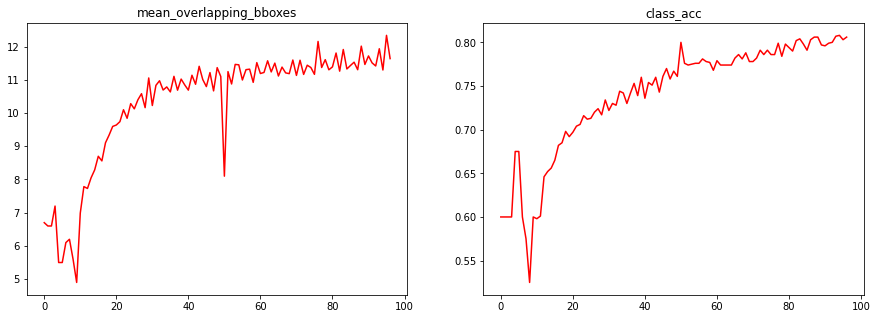

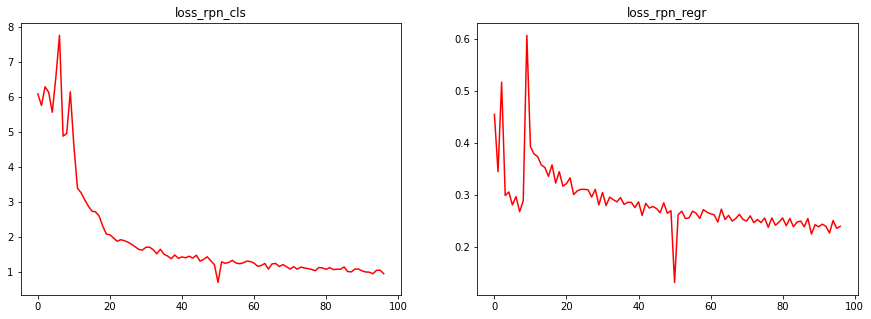

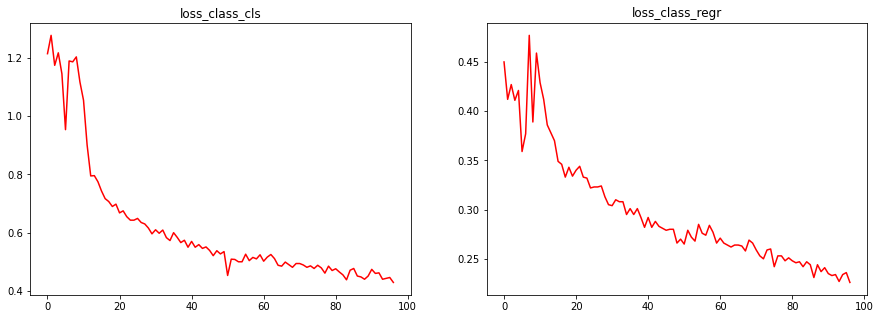

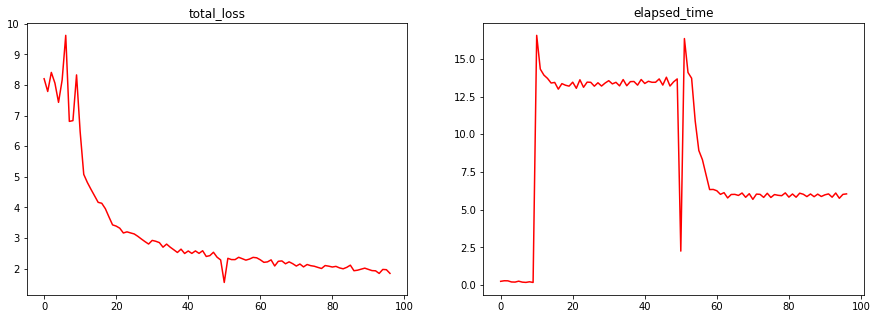

In [19]:
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

In [20]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [21]:
num_features = 512

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

shared_layers = nn_base(img_input, trainable=True)

num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=len(C.class_mapping))

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

Loading weights from drive/My Drive/AI/Faster_RCNN/model/model_frcnn_vgg.hdf5


In [22]:
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Person', 1: 'Car', 2: 'Mobile phone', 3: 'bg'}


In [23]:
test_imgs = os.listdir(test_base_path)

imgs_path = []
for i in range(12):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

all_imgs = []

classes = {}

In [24]:
bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    [Y1, Y2, F] = model_rpn.predict(X)

    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			if iou_map >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))

	for gt_box in gt:
		if not gt_box['bbox_matched']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	return T, P

In [26]:
def format_img_map(img, C):

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [27]:
print(class_mapping)

{0: 'Person', 1: 'Car', 2: 'Mobile phone', 3: 'bg'}


In [28]:
test_imgs, _, _ = get_data(test_path)

Parsing annotation files
idx=6

In [29]:
T = {}
P = {}
mAPs = []
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    X = np.transpose(X, (0, 2, 3, 1))

    [Y1, Y2, F] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):

            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.5)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)


    print('Elapsed time = {}'.format(time.time() - st))
    t, p = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    mAPs.append(np.mean(np.array(all_aps)))
    
print()
print('mean average precision:', np.mean(np.array(mAPs)))

0/4
Elapsed time = 0.7413778305053711
Mobile phone AP: nan
Person AP: 0.5873015873015872
mAP = nan
1/4


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


Elapsed time = 0.6697382926940918
Mobile phone AP: nan
Person AP: 0.3374542124542124
mAP = nan
2/4
Elapsed time = 0.7675139904022217
Mobile phone AP: 1.0
Person AP: 0.3374542124542124
mAP = 0.6687271062271062
3/4
Elapsed time = 0.6633243560791016
Mobile phone AP: 1.0
Person AP: 0.32857142857142857
Car AP: 1.0
mAP = 0.7761904761904761

mean average precision: nan


In [30]:
mAP = [mAP for mAP in mAPs if str(mAP)!='nan']
mean_average_prec = round(np.mean(np.array(mAP)), 3)
print('After training %dk batches, the mean average precision is %0.3f'%(len(record_df), mean_average_prec))

After training 97k batches, the mean average precision is 0.722


In [31]:
def predict( predict_imgs, bbox_threshold=0.5):
  bbox_threshold = bbox_threshold
  if len(predict_imgs) == 0:
    print("Please pass a list of images for prediction!")
  for idx, img_name in enumerate(predict_imgs):
      if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
          continue
      print(img_name)
      st = time.time()
      filepath = os.path.join(test_base_path, img_name)

      img = cv2.imread(filepath)

      X, ratio = format_img(img, C)
      
      X = np.transpose(X, (0, 2, 3, 1))

      [Y1, Y2, F] = model_rpn.predict(X)

      R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

      R[:, 2] -= R[:, 0]
      R[:, 3] -= R[:, 1]

      bboxes = {}
      probs = {}

      for jk in range(R.shape[0]//C.num_rois + 1):
          ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
          if ROIs.shape[1] == 0:
              break

          if jk == R.shape[0]//C.num_rois:
              curr_shape = ROIs.shape
              target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
              ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
              ROIs_padded[:, :curr_shape[1], :] = ROIs
              ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
              ROIs = ROIs_padded

          [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

          for ii in range(P_cls.shape[1]):
              if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                  continue

              cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

              if cls_name not in bboxes:
                  bboxes[cls_name] = []
                  probs[cls_name] = []

              (x, y, w, h) = ROIs[0, ii, :]

              cls_num = np.argmax(P_cls[0, ii, :])
              try:
                  (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                  tx /= C.classifier_regr_std[0]
                  ty /= C.classifier_regr_std[1]
                  tw /= C.classifier_regr_std[2]
                  th /= C.classifier_regr_std[3]
                  x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
              except:
                  pass
              bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
              probs[cls_name].append(np.max(P_cls[0, ii, :]))

      all_dets = []

      for key in bboxes:
          bbox = np.array(bboxes[key])

          new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
          for jk in range(new_boxes.shape[0]):
              (x1, y1, x2, y2) = new_boxes[jk,:]
              
              (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

              cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

              textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
              all_dets.append((key,100*new_probs[jk]))

              (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
              textOrg = (real_x1, real_y1-0)

              cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
              cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 1, textOrg[1]-retval[1] - 1), (255, 255, 255), -1)
              cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

      print('Elapsed time = {}'.format(time.time() - st))
      print(all_dets)
      plt.figure(figsize=(10,10))
      plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
      plt.show()

/content/drive/My Drive/Colab Notebooks/car.jpg
Elapsed time = 1.5009100437164307
[('Car', 99.50057864189148)]


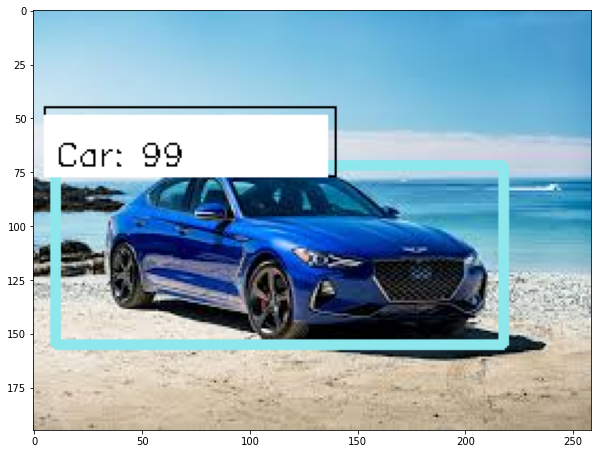

In [32]:
predict(["/content/drive/My Drive/Colab Notebooks/car.jpg"])

In [1]:
# help(Model.save)